In [2]:
import pandas as pd
import numpy as np
import os
import sys
#os.chdir('C:\\Users\\OtherCat\\Documents\\Code\\Bootleg_Macro')
os.chdir('/Users/jamesbishop/Documents/Python/Bootleg_Macro')
#os.chdir('/home/imbobbilly/Documents/Coding/Bootleg_Macro')
wd = %pwd
#vbt_dir = "C:\\Users\\OtherCat\\Documents\\Code\\vbt_tax"
vbt_dir = '/Users/jamesbishop/Documents/Financial/Investment/MACRO_STUDIES/CapWars_GLI/vbt_tax'
#vbt_dir = '/home/imbobbilly/Documents/Coding/Python/vbt_tax'
fdel = os.path.sep

sys.path.append(wd)
sys.path.append(vbt_dir)
import MacroBackend as mb

/Users/jamesbishop/Documents/miniconda3/envs/bm/lib/node_modules
/Users/jamesbishop/Documents/Python/Bootleg_Macro/MacroBackend /Users/jamesbishop/Documents/Python/Bootleg_Macro
Looking for api keys in SystemInfo folder... /Users/jamesbishop/Documents/Python/Bootleg_Macro/MacroBackend/SystemInfo/API_Keys.json


INFO - tedata package initialized successfully!


Looking for api keys in SystemInfo folder... /Users/jamesbishop/Documents/Python/Bootleg_Macro/MacroBackend/SystemInfo/API_Keys.json
System information:  darwin , directory delimiter:  / , working directory:  /Users/jamesbishop/Documents/Python/Bootleg_Macro/MacroBackend/Glassnode


In [3]:
vams_data = pd.read_excel(vbt_dir+fdel+"42M_BTC_VAMS.xlsx", index_col=0, parse_dates=True)
vams_data = vams_data.ffill().bfill()
dataf = pd.read_excel(vbt_dir+fdel+"42M_MacWeather_BTC.xlsx", index_col=0, parse_dates=True)

In [4]:
# Count NaN values in the signal column
nan_count = vams_data["signal"].isna().sum()

# Count the different signal values including NaNs
signal_counts = vams_data["signal"].value_counts(dropna=False)

# Display the results
print(f"Number of NaN values: {nan_count}")
print("\nSignal value counts:")
print(signal_counts)

Number of NaN values: 0

Signal value counts:
signal
green     1240
red        415
yellow     176
Name: count, dtype: int64


In [5]:
import vectorbt as vbt
import taxCalcs

# Assume your DataFrame is called 'data' and has columns 'BTCUSD' and 'signal'
price = vams_data['BTCUSD']
signal = vams_data['signal']

# Map signals to positions: 1 for green, 0.5 for yellow, 0 for red
signal_map = {'green': 1.0, 'yellow': 0.5, 'red': 0.0}
positions = signal.map(signal_map).fillna(1.0)

# For vectorbt, you need boolean entries/exits
entries1 = (positions.diff().fillna(0) > 0).shift(1).fillna(False).rename("entries") # Enter when position increases
exits1 = (positions.diff().fillna(0) < 0).shift(1).fillna(False).rename("exits")   # Exit when position decreases

# Create orders column: 1 for entries, -1 for exits, 0 otherwise
orders = pd.Series(0, index=positions.index)
orders[entries1] = 1
orders[exits1] = -1
orders = orders.rename("orders")
orders.iloc[0] = 1 # Set the first order to 1 to start the position

/var/folders/lj/yg38j90s0mq9l9mk98st457m0000gn/T/ipykernel_45237/1932870173.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entries1 = (positions.diff().fillna(0) > 0).shift(1).fillna(False).rename("entries") # Enter when position increases
/var/folders/lj/yg38j90s0mq9l9mk98st457m0000gn/T/ipykernel_45237/1932870173.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exits1 = (positions.diff().fillna(0) < 0).shift(1).fillna(False).rename("exits")   # Exit when position decreases


In [6]:
def clean_orders(order_series):
    # Convert to float and set all 0s to nan
    cleaned = order_series.astype(float).copy()
    cleaned[cleaned == 0] = np.nan

    # Only keep values strictly between -1.0 and 1.0 (excluding 0, which is already nan)
    mask = cleaned.abs().between(0, 1, inclusive='both')
    cleaned[~mask] = np.nan

    # Remove consecutive repeats (keep only the first of each run)
    last_value = np.nan
    for idx in cleaned.index:
        val = cleaned.loc[idx]
        if pd.isna(val):
            continue
        if val == last_value:
            cleaned.loc[idx] = np.nan
        else:
            last_value = val

    return cleaned

def create_size_diff(signal_series):
    size_diff = pd.Series(np.nan, index=signal_series.index)
    
    # Get previous signal for transition detection
    prev_signal = signal_series.shift(1)
    
    # Yellow to Green: 1.0
    yellow_to_green = (prev_signal == 'yellow') & (signal_series == 'green')
    red_to_green = (prev_signal == 'red') & (signal_series == 'green')
    size_diff[yellow_to_green | red_to_green] = 1.0
    
    # Green to Yellow OR Red to Yellow: 0.5
    green_to_yellow = (prev_signal == 'green') & (signal_series == 'yellow')
    red_to_yellow = (prev_signal == 'red') & (signal_series == 'yellow')
    size_diff[green_to_yellow | red_to_yellow] = 0.5
    
    # Yellow to Red: 0.0
    yellow_to_red = (prev_signal == 'yellow') & (signal_series == 'red')
    green_to_red = (prev_signal == 'green') & (signal_series == 'red')
    size_diff[yellow_to_red | green_to_red] = 0.0
    
    return size_diff


#### These two cells below helped to formulate the orders but now all the data can just be loaded as below

In [7]:
# Create a new orders series based on regime transitions in the 'signal' column
orders_regime = pd.Series(np.nan, index=signal.index, name='orders_regime')

# +1 when transitioning from yellow/red to green
green_entry = (signal == 'green') & (signal.shift(1).isin(['yellow', 'red']))
orders_regime[green_entry] = 1

# -1 when transitioning from green to yellow/red or green to red
green_exit = (signal.shift(1) == 'green') & (signal.isin(['yellow', 'red']))
orders_regime[green_exit] = 0

#Shift series a day as one could not put in a trade on the same day as a signal change.
orders_regime = orders_regime.shift(1)
# Buy on the first day
if signal.iloc[0] == "green":
    orders_regime.iloc[0] = 1
size = clean_orders(orders).replace(-1, 0)
# orders_regime = clean_orders(orders_regime)

size_diff = create_size_diff(signal).shift(1)
size_diff.iloc[0] = 1

# Combine everything into the checkit DataFrame
checkit = pd.concat([entries1, exits1, orders, size, orders_regime, size_diff, signal, price], axis=1).reset_index()
checkit.columns = ['date','entries', 'exits', 'orders', 'size', 'orders_regime', 'size_diff', 'signal', 'price']
checkit.set_index('date', inplace=True, drop=True)
checkit

,entries,exits,orders,size,orders_regime,size_diff,signal,price
date,,,,,,,,
2020-03-01,False,False,1,1.0,1.0,1.0,green,8917.4900
2020-03-02,False,False,0,NaN,NaN,NaN,green,8754.4925
2020-03-03,False,False,0,NaN,NaN,NaN,green,8757.4225
2020-03-04,False,False,0,NaN,NaN,NaN,yellow,9067.5425
2020-03-05,False,True,-1,0.0,0.0,0.5,red,9156.3050
...,...,...,...,...,...,...,...,...
2025-03-01,False,True,-1,0.0,0.0,0.5,yellow,94322.3700
2025-03-02,False,False,0,NaN,NaN,NaN,yellow,86235.9500
2025-03-03,False,False,0,NaN,NaN,NaN,yellow,87302.9900


In [8]:
checkit = pd.read_excel(vbt_dir+fdel+"all_data.xlsx", index_col=0)
checkit
#checkit["macweath_2"] = checkit["macWeath_coefficient"].copy()

,exits,orders,size,orders_regime,size_diff,signal,42M_KISS_Siggie,asset_(%),asset_diff(%),audusd,price,macWeath_coeff_2,macWeath_coefficient,weather_signal,KISSsig2,asset_diff2(%),mac_weath_only
2020-03-01,False,1,1.0,1.0,1.0,green,1.0,1.0,1.0,1.52850,8917.4900,1.0,1.0,green,1.0,1.0,1.0
2020-03-02,False,0,NaN,NaN,NaN,green,NaN,1.0,NaN,1.52850,8754.4925,1.0,1.0,green,1.0,NaN,NaN
2020-03-03,False,0,NaN,NaN,NaN,green,NaN,1.0,NaN,1.51840,8757.4225,1.0,1.0,green,1.0,NaN,NaN
2020-03-04,False,0,NaN,NaN,NaN,yellow,NaN,1.0,NaN,1.50840,9067.5425,1.0,1.0,green,1.0,NaN,NaN
2020-03-05,True,-1,0.0,0.0,0.5,red,0.0,0.0,0.0,1.51140,9156.3050,1.0,1.0,green,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-01,True,-1,0.0,0.0,0.5,yellow,0.0,0.0,0.0,1.60951,94322.3700,0.5,0.5,yellow,0.0,0.0,NaN
2025-03-02,False,0,NaN,NaN,NaN,yellow,NaN,0.0,NaN,1.60951,86235.9500,0.5,0.5,yellow,0.0,NaN,NaN
2025-03-03,False,0,NaN,NaN,NaN,yellow,NaN,0.0,NaN,1.60600,87302.9900,0.5,0.5,yellow,0.0,NaN,NaN
2025-03-04,False,0,NaN,NaN,NaN,yellow,NaN,0.0,NaN,1.59380,90668.2800,0.5,0.5,yellow,0.0,NaN,NaN


In [9]:
mw_recent = dataf.loc["2020-03-01":checkit.index[-1]].copy()
mw_recent = mw_recent.reindex(checkit.index).ffill()
# #mw_recent["macWeath_coefficient"] = mw_recent["signal"].apply(lambda x: 1.0 if x == "green" else 0.5)
# macWeath_coeff_3 = checkit["macWeath_coefficient"].copy()
# # Properly set macWeath_coeff_2 values for each signal type
# macWeath_coeff_3.loc[mw_recent["signal"] == "red"] = 0
# macWeath_coeff_3.loc[mw_recent["signal"] == "yellow"] = 0.5
# macWeath_coeff_3.loc[mw_recent["signal"] == "green"] = 1.0
# macWeath_coeff_3

In [ ]:
# mw_recent["KISS_size2"] = mw_recent["VAMS_size"] * mw_recent["target_allocation"]
# mw_recent["KISS_size"] = mw_recent["KISS_size2"].copy()
# for i in range(len(mw_recent["KISS_size2"][1:])):
#     if mw_recent["KISS_size2"].iloc[i] == mw_recent["KISS_size2"].iloc[i-1]:
#         mw_recent["KISS_size"].iloc[i] = np.nan
#     else:
#         mw_recent["KISS_size"].iloc[i] = mw_recent["KISS_size2"].iloc[i]
mw_recent.drop(columns=["KISS_size2"], inplace=True)
mw_recent

In [ ]:
# for i in range(len(mw_recent)):
#     if mw_recent.loc[mw_recent.index[i], "MWR_signal"] == "red":
#         mw_recent.loc[mw_recent.index[i],"MWR_size"] = 0.25
#     elif mw_recent.loc[mw_recent.index[i], "MWR_signal"] == "yellow":
#         mw_recent.loc[mw_recent.index[i],"MWR_size"] = 0.5
#     elif mw_recent.loc[mw_recent.index[i], "MWR_signal"]== "green":
#         mw_recent.loc[mw_recent.index[i],"MWR_size"] = 1.0
    
#     if mw_recent.loc[mw_recent.index[i], "VAMS"] == "red":
#         mw_recent.loc[mw_recent.index[i],"VAMS_size"] = 0.0
#     elif mw_recent.loc[mw_recent.index[i], "VAMS"] == "yellow":
#         mw_recent.loc[mw_recent.index[i],"VAMS_size"] = 0.5
#     elif mw_recent.loc[mw_recent.index[i], "VAMS"]== "green":
#         mw_recent.loc[mw_recent.index[i],"VAMS_size"] = 1.0
# mw_recent

,green,yellow,red,MWR_signal,BTCUSD,VAMS,VAMS_size,MWR_size
2020-03-01,1.0,0.0,0.0,green,8563.411686,green,1.0,1.0
2020-03-02,1.0,0.0,0.0,green,8563.411686,green,1.0,1.0
2020-03-03,1.0,0.0,0.0,green,8563.411686,green,1.0,1.0
2020-03-04,1.0,0.0,0.0,green,8563.411686,yellow,0.5,1.0
2020-03-05,1.0,0.0,0.0,green,8563.411686,red,0.0,1.0
...,...,...,...,...,...,...,...,...
2025-03-01,0.0,1.0,0.0,yellow,96292.847330,yellow,0.5,0.5
2025-03-02,0.0,1.0,0.0,yellow,94381.509291,yellow,0.5,0.5
2025-03-03,0.0,1.0,0.0,yellow,94381.509291,yellow,0.5,0.5
2025-03-04,0.0,1.0,0.0,yellow,94381.509291,yellow,0.5,0.5


In [ ]:
# mw_recent = dataf.loc["2020-03-01":checkit.index[-1]].copy()
# mw_recent["macWeath_coefficient"] = mw_recent["signal"].apply(lambda x: 1.0 if x == "green" else 0.5)

# mad_sig = mw_recent["macWeath_coefficient"].copy()
# mad_sig = mad_sig.reindex(index = checkit.index, method = "ffill")
# checkit = pd.concat([checkit, mad_sig], axis=1)
# checkit["42M_KISS_Siggie"] = checkit["orders_regime"]* checkit["macWeath_coefficient"]
#checkit.drop(columns={"macWeath_coefficient"}, inplace=True)
#ordat = checkit["42M_KISS_Siggie"]

# checkit["macWeath_coefficient_2"] = checkit["signal"].apply(lambda x: 1.0 if x == "green" else 0.5 if x == "yellow" else 0.25)
# checkit["asset_2(%)"] = checkit["orders_regime"].ffill() * checkit["macWeath_coefficient_2"]
# checkit["asset_diff2(%)"] = checkit["asset_2(%)"].diff()
# checkit

# checkit.loc[checkit.index[0], "asset_diff2(%)"] = 1.0
#checkit.drop("asset_diff(%)", axis = 1,  inplace = True)
# checkit.to_excel(vbt_dir+fdel+"all_data.xlsx", index=True)

In [ ]:
# Merge the AUDUSD data with the existing checkit DataFrame
# checkit["mac_weath_only"] = macWeath_coeff_3.copy()
# checkit["mac_weath_only"].loc[checkit.index[0]] = 1
# for i in range(len(checkit[1:])):
#     if macWeath_coeff_3.loc[checkit.index[i]] == macWeath_coeff_3.loc[checkit.index[i-1]]:
#         checkit.loc[checkit.index[i], "mac_weath_only"] = np.nan
#     else:
#         pass
# checkit["mac_weath_only"]
#checkit.to_excel(vbt_dir+fdel+"all_data.xlsx", index=True)

In [ ]:
# checkit.to_excel(vbt_dir+fdel+"all_data.xlsx", index=True)

In [ ]:
fees = 0.0035

# Buy & Hold control - for comparison - benchmark
bh_pf = vbt.Portfolio.from_holding(
    price,
    init_cash=10000,
    freq='1D',
    fees=fees
)

# Run the strategy
full_inout = vbt.Portfolio.from_signals(
    price,
    entries=entries1,
    exits=exits1,
    init_cash=10000,
    freq='1D',
    fees=fees# 1% fees per trade
)

inout_ords = vbt.Portfolio.from_orders(
    price,
    size=size,
    direction="longonly",
    size_type='targetpercent',
    init_cash=10000,
    freq='1D',
    fees=fees # 1% fees per trade
)

less_ords = vbt.Portfolio.from_orders(
    price,
    size=orders_regime,
    direction="longonly",
    size_type='targetpercent',
    init_cash=10000,
    freq='1D',
    fees=fees # 1% fees per trade
)

cpf_fo = vbt.Portfolio.from_orders(
    price,
    size=size_diff,
    direction="longonly",
    size_type="targetpercent",
    init_cash=10000,
    freq='1D',
    fees=fees
)

full_sig = vbt.Portfolio.from_orders(
    checkit["price"],
    size=checkit["42M_KISS_Siggie"],
    direction="longonly",
    size_type="targetpercent",
    init_cash=10000,
    freq='1D',
    fees=fees 
)

full_sig_mod = vbt.Portfolio.from_orders(
    checkit["price"],
    size=checkit["asset_diff(%)"],
    direction="longonly",
    size_type="targetpercent",
    init_cash=10000,
    freq='1D',
    fees=fees 
)

full_sig_mod2 = vbt.Portfolio.from_orders(
    checkit["price"],
    size=checkit["asset_diff2(%)"],
    direction="longonly",
    size_type="targetpercent",
    init_cash=10000,
    freq='1D',
    fees=fees 
)

mwr_only = vbt.Portfolio.from_orders(
    checkit["price"],
    size=checkit["mac_weath_only"],
    direction="longonly",
    size_type="targetpercent",
    init_cash=10000,
    freq='1D',
    fees=fees 
)

# kiss = vbt.Portfolio.from_orders(
#     checkit["price"],
#     size=mw_recent["KISS_size"],
#     direction="longonly",
#     size_type="targetpercent",
#     init_cash=10000,
#     freq='1D',
#     fees=0.0035 # 1% fees per trade
# )

# Save the portfolios to a dictionary for easy access
portfolios_no_tax = {
    '0: bh_pf': bh_pf,
    '1: full_inout': full_inout,
    '2: inout_ords': inout_ords,
    '3: less_ords': less_ords,
    '4: cpf_fo': cpf_fo,
    '5: full_sig': full_sig,
    '6: full_sig_mod': full_sig_mod,
    '7: full_sig_mod2': full_sig_mod2,
    '8: mwr_only': mwr_only,
    # '9: kiss': kiss
}

In [12]:
fullstats = pd.concat([bh_pf.stats(), inout_ords.stats(), less_ords.stats(), cpf_fo.stats(), full_sig.stats(), full_sig_mod.stats(), full_sig_mod2.stats(), mwr_only.stats()], axis=1)
fullstats.columns = ['Buy & Hold (benchmark)',  'All in/out on signal change', 'Long green, sell yellow/red', "Signal dep. sizing", "VAMS + MacWeath", 
                     "VAMS + MacWeath #2", "VAMS + MacWeath #3", "Macro Weather Only"]
fullstats.to_excel(vbt_dir+fdel+"42M_MacWeather_BTC_Stats.xlsx")
fullstats

,Buy & Hold (benchmark),All in/out on signal change,"Long green, sell yellow/red",Signal dep. sizing,VAMS + MacWeath,VAMS + MacWeath #2,VAMS + MacWeath #3,Macro Weather Only
Start,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00
End,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00
Period,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00
Start Value,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
End Value,100538.790869,149009.876999,165512.658278,133564.734484,162764.904706,166135.470821,173196.82049,158571.429043
Total Return [%],905.387909,1390.09877,1555.126583,1235.647345,1527.649047,1561.354708,1631.968205,1485.71429
Benchmark Return [%],908.906766,908.906766,908.906766,908.906766,908.906766,908.906766,908.906766,908.906766
Max Gross Exposure [%],100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
Total Fees Paid,34.877927,9382.579178,7302.532986,5829.146207,5324.282366,5744.913824,6676.723993,4707.673161
Max Drawdown [%],76.670182,49.405077,45.062534,50.666528,39.679428,36.567968,33.405757,53.23177


In [108]:
returns = pd.concat([bh_pf.value(), inout_ords.value(), less_ords.value(), cpf_fo.value(), full_sig.value(), full_sig_mod.value(), full_sig_mod2.value(), mwr_only.value()], axis=1)
returns.columns = ['Buy & Hold (benchmark)',  'All in/out on signal change', 'Long green, sell yellow/red', "Signal dep. sizing", "VAMS + MacWeath", 
                     "VAMS + MacWeath #2", "VAMS + MacWeath #3", "Macro Weather Only"]

# Divide all columns by the benchmark column
returns_rel = returns.div(returns['Buy & Hold (benchmark)'], axis=0) * 100
returns_rel -=100

In [ ]:
# title = f'Bitcoin trading using 42 MACRO VAMS Signal vs <i>hAvInG dIaMoNd hAnDs. With Tax Payments\
#     <br><sub><b>Values 2025-03-05: strategy #6: </b>{pf5tax.value().iloc[-1]:.2f} USD, <b>Strategy #6 no CGT discount: </b> {pf6tax.value().iloc[-1]:.2f} USD <b>Hodler: </b>{hodler_final_val_series.iloc[-1]:.2f} USD</sub>'
plotThese = {returns_rel.columns[i]: returns_rel[returns_rel.columns[i]] for i in range(len(returns_rel.columns))}
relatives = taxCalcs.plot_portfolios(plotThese, title = "Strategy Returns relative to the Benchmark (hodling)", return_fig = True)#"BTC: trading using 42 MACRO VAMS Signal vs hAvInG dIaMoNd hAnDs")
relatives.update_layout(
    yaxis_title="Returns relative to hOdLiNg (%)",
    log_y=False,
)
relatives.show()

In [98]:
relatives.write_image(vbt_dir+fdel+"relative_returns.png", scale = 3)
relatives.write_html(vbt_dir+fdel+"relative_returns.html")

In [13]:
# Make a copy of the DataFrame
rounded_stats = fullstats.copy()

# Define columns that should keep their original values exactly as they are
preserve_exact_columns = ['Total Trades', 'Total Closed Trades', 'Total Open Trades']

# Process the DataFrame for proper rounding
for col in rounded_stats.columns:
    for idx in rounded_stats.index:
        value = rounded_stats.loc[idx, col]
        
        # Handle date/time values
        if idx == 'Start' or idx == 'End':
            # Convert datetime to date only (strip time)
            if hasattr(value, 'date'):
                rounded_stats.loc[idx, col] = value.date()
            continue
            
        # Handle duration values
        if idx == 'Period' or idx == 'Max Drawdown Duration' or 'Duration' in idx:
            # If it's a timedelta or a string representing a duration
            if hasattr(value, 'days'):
                # Just keep days for timedeltas
                rounded_stats.loc[idx, col] = f"{value.days} days"
            elif isinstance(value, str) and 'days' in value:
                # Extract just the days portion from strings like "846 days 00:00:00"
                days = value.split(' days')[0]
                rounded_stats.loc[idx, col] = f"{days} days"
            continue
        
        # Skip exact preserved columns
        if idx in preserve_exact_columns:
            continue
        
        # Handle NaN values
        if pd.isna(value):
            continue
            
        # Round numeric values
        try:
            if isinstance(value, (int, float)) or (isinstance(value, str) and value.replace('.', '', 1).isdigit()):
                num_value = float(value)
                rounded_stats.loc[idx, col] = round(num_value, 2)
        except (ValueError, TypeError):
            # Keep the original value if conversion fails
            pass

# Display the rounded DataFrame
rounded_stats

,Buy & Hold (benchmark),All in/out on signal change,"Long green, sell yellow/red",Signal dep. sizing,VAMS + MacWeath,VAMS + MacWeath #2,VAMS + MacWeath #3,Macro Weather Only
Start,2020-03-01,2020-03-01,2020-03-01,2020-03-01,2020-03-01,2020-03-01,2020-03-01,2020-03-01
End,2025-03-05,2025-03-05,2025-03-05,2025-03-05,2025-03-05,2025-03-05,2025-03-05,2025-03-05
Period,1831 days,1831 days,1831 days,1831 days,1831 days,1831 days,1831 days,1831 days
Start Value,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
End Value,100538.79,149009.88,165512.66,133564.73,162764.9,166135.47,173196.82,158571.43
Total Return [%],905.39,1390.1,1555.13,1235.65,1527.65,1561.35,1631.97,1485.71
Benchmark Return [%],908.91,908.91,908.91,908.91,908.91,908.91,908.91,908.91
Max Gross Exposure [%],100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
Total Fees Paid,34.88,9382.58,7302.53,5829.15,5324.28,5744.91,6676.72,4707.67
Max Drawdown [%],76.67,49.41,45.06,50.67,39.68,36.57,33.41,53.23


In [14]:
rounded_stats.to_markdown()

'|                            | Buy & Hold (benchmark)   | All in/out on signal change   | Long green, sell yellow/red   | Signal dep. sizing   | VAMS + MacWeath   | VAMS + MacWeath #2   | VAMS + MacWeath #3   | Macro Weather Only   |\n|:---------------------------|:-------------------------|:------------------------------|:------------------------------|:---------------------|:------------------|:---------------------|:---------------------|:---------------------|\n| Start                      | 2020-03-01               | 2020-03-01                    | 2020-03-01                    | 2020-03-01           | 2020-03-01        | 2020-03-01           | 2020-03-01           | 2020-03-01           |\n| End                        | 2025-03-05               | 2025-03-05                    | 2025-03-05                    | 2025-03-05           | 2025-03-05        | 2025-03-05           | 2025-03-05           | 2025-03-05           |\n| Period                     | 1831 days                | 1

In [101]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add each portfolio's value curve
portfolios = {
    '#0: HoDlEr': bh_pf,
    '#1: VAMS signal change': inout_ords,
    '#2: Long green, sell yellow/red': less_ords,
    '#3: VAMS dep. size': cpf_fo,
    '#4: VAMS + MWR': full_sig,
    '#5: VAMS + MWR #2': full_sig_mod,
    '#6: VAMS + MWR#3': full_sig_mod2,
    '#7: MWR  Only': mwr_only,
}

for name, pf in portfolios.items():
    fig.add_trace(
        go.Scatter(
            x=pf.value().index,
            y=np.round(pf.value().values, 0),
            name=name,
            mode='lines',
            line=dict(width=1.5)
        )
    )

# Update layout with horizontal legend at bottom
fig.update_layout(
    title='BTC Trading using 42 MACRO VAMS and Macro Weather regime',
    yaxis_title='Portfolio Value ($)',
    template='plotly_white',
    width=1100,
    height=600,
    yaxis_type='log',
    showlegend=True,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show the figure
fig.show()

In [102]:
fig.write_html(vbt_dir+fdel+"42Macro_VAMSStrats.html")

In [17]:
# audusd = mb.Pull_Data.dataset()
# audusd.get_data("tv", "USDAUD", exchange_code="FX_IDC", start_date="2020-03-01", end_date="2025-03-05", data_freq="1d", dtype="close")

In [18]:
# checkit["audusd"] = audusd.data["2020-03-01":"2025-03-05"].resample("D").ffill().bfill()
# df = pd.concat([price, aud], axis = 1).bfill()
# aud = df["USDAUD"]
# aud.to_excel(vbt_dir+fdel+"AUDUSD.xlsx", sheet_name="AUDUSD", index=True)
# aud = pd.read_excel(vbt_dir+fdel+"AUDUSD.xlsx", index_col=0, parse_dates=True)

In [19]:
trades = taxCalcs.create_trades_df(full_sig_mod2, checkit["price"], checkit["audusd"], checkit["asset_diff2(%)"])
tax, trades = taxCalcs.tax_calc(trades, 100000)
print(trades, tax)

Number of trades: 24
Price date range: 2020-03-01 00:00:00 to 2025-03-05 00:00:00
Using default tax information for Australia from 2019 - 2025.
Income λιστ μαδε: [100000, 100000, 100000, 100000, 100000, 100000]
         id      size  entry_idx   entry_price  entry_fees  exit_idx  \
0    2020_0  1.117481          0   8917.490000   34.877927         4   
1    2020_1  1.288253          8   7887.130000   35.562167         9   
2    2020_2  1.635982         18   6207.055000   35.541206       441   
3    2021_3  0.474416        513  40026.427500   66.462057       525   
4    2021_4  0.749995        513  45719.782189  120.013591       575   
5    2021_5  0.959967        578  54601.213699  183.453787       616   
6    2021_6  0.319989        578  54601.213699   61.151262       645   
7    2022_7  0.457557        708  44133.220000   70.677181       719   
8    2022_8  0.444414        753  44325.510000   68.946033       769   
9    2022_9  0.836386        870  23223.960000   67.984643       904 

### Payable tax formula: 

$Tax_{net} = ((I_{g} - D) - Threshold_{\beta}) \times Rate_{\beta} + Base_{\beta}$

**Where:**
- $I_{g}$ is gross taxable income.
- $D$ are eligible tax deductions gross total.
- $(I_{g} - D)$ is net taxable income.
- $\beta$ idicates the tax bracket applicable.
- $Threshold_{\beta}$ is minimum threshold for tax bracket
- $Rate_{\beta}$ is tax rate for bracket (%)
- $Base_{\beta}$ is base tax amount for bracket.


## New tax calculation backtest..

```python
def run_backtest_with_tax(
    price: pd.Series,
    orders: pd.Series,
    aud: pd.Series,
    init_cash: float,
    income: Union[float, list],
    deductions: Union[float, list] = 0,
    tax_rates: pd.DataFrame = None,
    freq: str = '1D'
) -> vbt.Portfolio:
```

In [20]:
years = price.index.year.unique()
income = pd.Series([91000, 93000, 96000, 103000, 112000, 117000], index=years)
cgt_list = pd.Series([1.0, 0.5, 1.0, 1.0, 1.0, 1.0], index=years)
deductions = pd.Series([5000, 4200, 2200, 5000, 6000, 7500], index=years)
years

Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')

In [21]:
# Create a salary series with 3% annual growth
base_salary = 91000  # Starting salary
growth_rate = 0.03   # 3% annual growth
num_years = len(years)
salaries = np.array([base_salary * (1 + growth_rate)**i for i in range(num_years)])
salaries.tolist()

[91000.0, 93730.0, 96541.9, 99438.157, 102421.30171000001, 105493.94076130001]

In [22]:
pfnotax, pftax, details = taxCalcs.run_backtest_with_tax(price, checkit["orders_regime"], checkit["audusd"], 10000, salaries.tolist())

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for p

In [23]:
df = details["taxed"]["all_trades"].reset_index(drop=True)
df

,id,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl_(USD),return_(%),entry_date,exit_date,duration_(days),entry_signal,exit_signal,pay_cgt,financial_year,pnl_(AUD),cgt_rate,cgt_amount_(AUD)
0,2020_0,1.121392,0,8917.4900,0.0,4,9156.3050,0.0,267.805178,2.678052,2020-03-01,2020-03-05,4,1.0,0.0,paid_2020,2020,404.760747,1.0,404.760747
1,2020_1,1.301843,8,7887.1300,0.0,9,7937.8525,0.0,66.032733,0.643105,2020-03-09,2020-03-10,1,1.0,0.0,paid_2020,2020,101.658053,1.0,101.658053
2,2020_2,1.664854,18,6207.0550,0.0,121,9236.3850,0.0,5043.390980,48.804626,2020-03-19,2020-06-30,743,1.0,NaN,paid_2021,2020,7305.200533,0.5,3652.600266
3,2020_0,1.656021,0,9236.3850,0.0,320,43577.1775,0.0,56869.084793,371.799059,2020-06-30,2021-05-16,743,NaN,0.0,paid_2021,2021,73054.026326,0.5,36527.013163
4,2021_0,1.608180,27,40026.4275,0.0,89,41038.1150,0.0,1626.975676,2.527549,2021-07-27,2021-09-27,62,1.0,0.0,paid_2022,2022,2232.096739,1.0,2232.096739
5,2021_1,1.370166,92,48166.9200,0.0,159,50644.3700,0.0,3394.517890,5.143468,2021-09-30,2021-12-06,67,1.0,0.0,paid_2022,2022,4812.815355,1.0,4812.815355
6,2022_2,1.572312,222,44133.2200,0.0,233,40104.1000,0.0,-6335.034199,-9.129449,2022-02-07,2022-02-18,11,1.0,0.0,paid_2022,2022,-8826.603149,1.0,-8826.603149
7,2022_3,1.422570,267,44325.5100,0.0,283,42155.8800,0.0,-3086.451608,-4.894766,2022-03-24,2022-04-09,16,1.0,0.0,paid_2022,2022,-4136.153800,1.0,-4136.153800
8,2022_0,2.582235,19,23223.9600,0.0,53,21523.0000,0.0,-4392.277598,-7.324160,2022-07-19,2022-08-22,34,1.0,0.0,paid_2023,2023,-6386.371628,1.0,-6386.371628
9,2023_1,2.661222,198,20884.1800,0.0,348,25130.0600,0.0,11299.228028,20.330604,2023-01-14,2023-06-13,150,1.0,0.0,paid_2023,2023,16693.366497,1.0,16693.366497


In [24]:
tax_details = details["taxed"]["tax_details"]
tax_details

,2020,2021,2022,2023,2024,2025
closed_PnL_(AUD),506.418799,80359.226858,-5917.844855,10306.994869,100091.183811,37278.717522
cgt_amount_(AUD),506.418799,40179.613429,-5917.844855,10306.994869,100091.183811,37278.717522
salary_income_(AUD),91000.0,93730.0,96541.9,99438.157,102421.30171,105493.940761
gross_taxable_income_(AUD),91506.418799,133909.613429,96541.9,109745.151869,202512.485521,142772.658283
gross_deductions_(AUD),0,-38.759856,0,5917.844855,-278.703892,0
net_taxable_income_(AUD),91506.418799,133948.373285,96541.9,103827.307014,202791.189413,142772.658283
tax_bracket,B,B,C,C,A,B
bracket_min_(aud),90001.0,120001.0,45001.0,45001.0,180001.0,135001.0
base_tax_(aud),20797.0,29467.0,5092.0,5092.0,51667.0,31288.0
tax_rate_(%),37.0,37.0,32.5,32.5,45.0,37.0


In [25]:
rates = taxCalcs.defaultTaxRates()
rates
# rates_small = rates.loc[2025].drop(columns=["base_tax_aud", "bracket_max_aud"])
# rates_small.columns = ["Tax Bracket", "Tax rate (%)", "Income threshold (AUD per year)"]
# rates_small

Using default tax information for Australia from 2019 - 2025.


,bracket,tax_rate_(%),base_tax_aud,bracket_min_aud,bracket_max_aud,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
financial_year,,,,,,,,,,,,,,,
2020.0,E,0.0,0.0,0.0,18200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020.0,D,19.0,0.0,18201.0,37000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020.0,C,32.5,3572.0,37001.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020.0,B,37.0,20797.0,90001.0,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020.0,A,45.0,54097.0,180001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.0,E,0.0,0.0,0.0,18200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.0,D,19.0,0.0,18201.0,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.0,C,32.5,5092.0,45001.0,120000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.0,B,37.0,29467.0,120001.0,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
full_sig_mod2.trades.records_readable

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,1.117481,2020-03-01,8917.490000,34.877927,2020-03-05,9156.3050,35.811976,196.181226,0.019687,Long,Closed,0
1,1,0,1.288253,2020-03-09,7887.130000,35.562167,2020-03-10,7937.8525,35.790869,-6.009621,-0.000591,Long,Closed,1
2,2,0,1.635982,2020-03-19,6207.055000,35.541206,2021-05-16,43577.1775,249.520177,60851.787238,5.992516,Long,Closed,2
3,3,0,0.474416,2021-07-27,40026.427500,66.462057,2021-08-08,46291.1750,76.864384,2828.767101,0.148967,Long,Closed,3
4,4,0,0.749995,2021-07-27,45719.782189,120.013591,2021-09-27,41038.1150,107.724300,-3738.963775,-0.109041,Long,Closed,3
5,5,0,0.959967,2021-09-30,54601.213699,183.453787,2021-11-07,67556.4625,226.981931,12026.176682,0.229440,Long,Closed,4
6,6,0,0.319989,2021-09-30,54601.213699,61.151262,2021-12-06,50644.3700,56.719749,-1384.017580,-0.079214,Long,Closed,4
7,7,0,0.457557,2022-02-07,44133.220000,70.677181,2022-02-18,40104.1000,64.224744,-1978.455498,-0.097975,Long,Closed,5
8,8,0,0.444414,2022-03-24,44325.510000,68.946033,2022-04-09,42155.8800,65.571286,-1098.730738,-0.055776,Long,Closed,6
9,9,0,0.836386,2022-07-19,23223.960000,67.984643,2022-08-22,21523.0000,63.005339,-1553.648289,-0.079985,Long,Closed,7


In [27]:
index = pd.date_range(start="2020-01-01", end="2025-01-01", freq="YS")
index 

DatetimeIndex(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01', '2025-01-01'],
              dtype='datetime64[ns]', freq='YS-JAN')

In [28]:
import plotly.express as px

# Get the tax details from the dictionary
tax_details = details["taxed"]["tax_details"]

# Create a bar chart of CGT tax paid in USD
fig = px.bar(
    x=index,
    y=tax_details.loc["cgt_tax_paid_(usd)"].values,
    labels={"x": "Financial Year", "y": "CGT Tax Paid (USD)"},
    title="Capital Gains Tax Paid Per Financial Year (USD)",
    text_auto='.2f'
)

# Improve layout
fig.update_layout(
    xaxis_title="Financial Year",
    yaxis_title="CGT Tax Paid (USD)",
    template="plotly_white",
    width=800,
    height=500
)

# Display the figure
fig.show()

In [29]:
def plot_timeseries_with_markers(timeseries, marker_dates_dict=None, figsize=(12,6)):
    """Plot a timeseries with optional vertical lines at specified dates
    
    Args:
        timeseries: pandas Series with DatetimeIndex
        marker_dates_dict: dict where keys are colors and values are DatetimeIndex of dates to mark
        figsize: tuple specifying figure size
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(timeseries.index, timeseries.values)
    
    if marker_dates_dict:
        for color, dates in marker_dates_dict.items():
            for date in dates:
                ax.axvline(x=date, color=color, alpha=0.3, linestyle='--')
    
    plt.grid(True, alpha=0.3)
    return fig



#FUNCTIONS #########################################################################################################################

In [30]:
aud_mar5 = checkit["audusd"].iloc[-1]
hodler_sell_mar5 = 100890.676637 - 10000 # Initial position was 10 k$ USD, so capgains are all on top of that
inaud = hodler_sell_mar5*checkit["audusd"].iloc[-1]
salary_income_2025 = 105493.940761
total_income = inaud*0.5 + salary_income_2025
print(f"Total income: {total_income} AUD, {total_income/aud_mar5} USD")
tax_that_Year = (total_income - 135001)*0.37 + 31288
cgt_hodler = (inaud/total_income)*tax_that_Year
final_hodler_value = bh_pf.value().iloc[-1] - cgt_hodler/checkit["audusd"].iloc[-1]
print(f"Final hodler value: {final_hodler_value} USD\nCGT tax paid: {cgt_hodler} AUD, {cgt_hodler/aud_mar5} USD")

Total income: 177202.14009376115 AUD, 112302.51606170299 USD
Final hodler value: 76481.55965106035 USD
CGT tax paid: 37959.905138072645 AUD, 24057.23121748694 USD


In [31]:
details["taxed"]["tax_details"].loc["cgt_tax_paid_(usd)"].sum()

np.float64(35466.102583742104)

In [32]:
hodler_final_val_series = bh_pf.value().copy()
hodler_final_val_series.iloc[-1] -= cgt_hodler/checkit["audusd"].iloc[-1]

In [33]:
pf2, pf2tax, details2 = taxCalcs.run_backtest_with_tax(price, checkit["orders_regime"], checkit["audusd"], 10000, salaries.tolist(), special_conditions={"constant_cgt_rate": 1.0})

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for p

In [34]:
details2["taxed"]["tax_details"]

,2020,2021,2022,2023,2024,2025
closed_PnL_(AUD),506.418799,80359.226858,-5058.684268,8810.611645,85552.127186,32076.945283
cgt_amount_(AUD),506.418799,80359.226858,-5058.684268,8810.611645,85552.127186,32076.945283
salary_income_(AUD),91000.0,93730.0,96541.9,99438.157,102421.30171,105493.940761
gross_taxable_income_(AUD),91506.418799,174089.226858,96541.9,108248.768645,187973.428896,137570.886045
gross_deductions_(AUD),0,-38.759856,0,5058.684268,-239.468542,0
net_taxable_income_(AUD),91506.418799,174127.986715,96541.9,103190.084377,188212.897438,137570.886045
tax_bracket,B,B,C,C,A,B
bracket_min_(aud),90001.0,120001.0,45001.0,45001.0,180001.0,135001.0
base_tax_(aud),20797.0,29467.0,5092.0,5092.0,51667.0,31288.0
tax_rate_(%),37.0,37.0,32.5,32.5,45.0,37.0


In [35]:
pf3, pf3tax, details3 = taxCalcs.run_backtest_with_tax(price, checkit["42M_KISS_Siggie"], checkit["audusd"], 10000, salaries.tolist())#, special_conditions={"constant_cgt_rate": 1.0})

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for p

In [36]:
pf4, pf4tax, details4 = taxCalcs.run_backtest_with_tax(price, checkit["asset_diff(%)"], checkit["audusd"], 10000, salaries.tolist())
pf5, pf5tax, details5 = taxCalcs.run_backtest_with_tax(price, checkit["asset_diff2(%)"], checkit["audusd"], 10000, salaries.tolist(), deductions=[0, 0, 0, 0, 0, 0])#, special_conditions={"constant_cgt_rate": 1.0})

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for p

In [37]:
details5["taxed"]["tax_details"]

,2020,2021,2022,2023,2024,2025
closed_PnL_(AUD),506.418799,80359.226858,9393.640466,31762.901083,94360.755448,6901.652839
cgt_amount_(AUD),506.418799,40179.613429,9393.640466,31762.901083,94360.755448,6901.652839
salary_income_(AUD),91000.0,93730.0,96541.9,99438.157,102421.30171,105493.940761
gross_taxable_income_(AUD),91506.418799,133909.613429,105935.540466,131201.058083,196782.057158,112395.593601
gross_deductions_(AUD),0,-38.759856,0,0,0,0
net_taxable_income_(AUD),91506.418799,133948.373285,105935.540466,131201.058083,196782.057158,112395.593601
tax_bracket,B,B,C,B,A,C
bracket_min_(aud),90001.0,120001.0,45001.0,120001.0,180001.0,45001.0
base_tax_(aud),20797.0,29467.0,5092.0,29467.0,51667.0,4288.0
tax_rate_(%),37.0,37.0,32.5,37.0,45.0,30.0


In [86]:
hodler_final_return = (hodler_final_val_series.iloc[-1]/10000)*100 - 100
hodler_final_return 


np.float64(664.8155965106035)

In [93]:
fin_rel = details5["taxed"]["end_value"] /hodler_final_val_series.iloc[-1]
fin_rel = (fin_rel - 1) * 100
print(f"Final return relative to hodler: {fin_rel:.2f}%")

Final return relative to hodler: 73.24%


In [96]:
details5["taxed"]["end_value"] - hodler_final_val_series.iloc[-1]

np.float64(56014.26589025467)

In [39]:
pf6, pf6tax, details6 = taxCalcs.run_backtest_with_tax(price, checkit["asset_diff2(%)"], checkit["audusd"], 10000, salaries.tolist(), special_conditions={"constant_cgt_rate": 1.0})

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for p

In [40]:
pf7, pf7tax, details7 = taxCalcs.run_backtest_with_tax(price, checkit["mac_weath_only"], checkit["audusd"], 10000, salaries.tolist())#, special_conditions={"constant_cgt_rate": 1.0})

Backtest price data runs from: 2020-03-01 00:00:00 to 2025-03-05 00:00:00, years: Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int32')
For financial year: 2020
Start date: 2020-03-01 00:00:00
End date: 2020-06-30 00:00:00
For financial year: 2021
Start date: 2020-06-30 00:00:00
End date: 2021-06-30 00:00:00
For financial year: 2022
Start date: 2021-06-30 00:00:00
End date: 2022-06-30 00:00:00
For financial year: 2023
Start date: 2022-06-30 00:00:00
End date: 2023-06-30 00:00:00
For financial year: 2024
Start date: 2023-06-30 00:00:00
End date: 2024-06-30 00:00:00
For financial year: 2025
Start date: 2024-06-30 00:00:00
End date: 2025-03-05 00:00:00

Running backtest for financial year: 2020
Order dates for 2020: [Timestamp('2020-03-01 00:00:00')]
Before backtest, pf - Current cash: 10000, current assets: 0, current value: 10000
Order values for pf: mac_weath_only
1.0    1
Name: count, dtype: int64
New trades df for 2020, deferred trade left from last year: 
Number of trades: 1
Pr

In [103]:
# "NoTaxCalc": less_ords, "1 BT per FY (no tax)": pfnotax, "1 BT per FY (taxed)": pftax,
# </i><br><sub>Tax payment simulation included for Australian who earnt 90k AUD in 2020 with 3% wage growth. CGT paid for 2025 on last day of backtest.</sub><br>
title = f'Bitcoin trading using 42 MACRO VAMS Signal vs <i>hAvInG dIaMoNd hAnDs. With Tax Payments\
    <br><sub><b>Values 2025-03-05: strategy #6: </b>{pf5tax.value().iloc[-1]:.2f} USD, <b>Strategy #6 no CGT discount: </b> {pf6tax.value().iloc[-1]:.2f} USD <b>Hodler: </b>{hodler_final_val_series.iloc[-1]:.2f} USD</sub>'
compfig = taxCalcs.plot_portfolios({"hOdLeR, tax": hodler_final_val_series, "#3, no tax": pfnotax.value(),
                                    "#2, tax": pftax.value(), "#2, tax, no CGT discount": pf2tax.value(), "#4, tax": pf3tax.value(),
                                   "#6, tax": pf5tax.value(), "#6, tax, no CGT discount": pf6tax.value(), "#7, tax": pf7tax.value()},
                                   title = title, return_fig = True)#"BTC: trading using 42 MACRO VAMS Signal vs hAvInG dIaMoNd hAnDs")
compfig.show()

In [104]:
compfig.write_html(vbt_dir+fdel+"WithCGTPayments.html")

In [43]:
lo_sharpe = less_ords.stats()["Sharpe Ratio"]
cp_sharpe = cpf_fo.stats()["Sharpe Ratio"]
full_sharpe = full_sig.stats()["Sharpe Ratio"]
full_sharpe2 = full_sig_mod.stats()["Sharpe Ratio"]
full_sharpe3 =full_sig_mod2.stats()["Sharpe Ratio"]
mwr_sharpe = mwr_only.stats()["Sharpe Ratio"]

In [71]:
full_sig_mod2.stats().index

Index(['Start', 'End', 'Period', 'Start Value', 'End Value',
       'Total Return [%]', 'Benchmark Return [%]', 'Max Gross Exposure [%]',
       'Total Fees Paid', 'Max Drawdown [%]', 'Max Drawdown Duration',
       'Total Trades', 'Total Closed Trades', 'Total Open Trades',
       'Open Trade PnL', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]',
       'Avg Winning Trade [%]', 'Avg Losing Trade [%]',
       'Avg Winning Trade Duration', 'Avg Losing Trade Duration',
       'Profit Factor', 'Expectancy', 'Sharpe Ratio', 'Calmar Ratio',
       'Omega Ratio', 'Sortino Ratio'],
      dtype='object')

In [105]:
# "NoTaxCalc": less_ords, "1 BT per FY (no tax)": pfnotax, "1 BT per FY (taxed)": pftax,
#<br><sub> Macro weather regime (MWR) adds coefficient to position size. MWR bullish = no reduction to position size,when neutral/bearish, position size reduced.

# Add each portfolio's value curve
portfolios = {
    '#0: HoDlEr': bh_pf,
    '#1: VAMS signal change': inout_ords,
    '#2: Long green, sell yellow/red': less_ords,
    '#3: VAMS dep. size': cpf_fo,
    '#4: VAMS + MWR': full_sig,
    '#5: VAMS + MWR #2': full_sig_mod,
    '#6: VAMS + MWR#3': full_sig_mod2,
    '#7: MWR  Only': mwr_only,
}

title = f"BTC: trading using 42 MACRO VAMS and Macro Weather Regime Overlay vs <i>hAvInG dIaMoNd hAnDs</i> <br> <sub> Strategy #6 perfoms best. \
<b>Final value strategy: </b>{full_sig_mod2.value().iloc[-1]:.2f} USD, <b>final value hodler: </b>{bh_pf.value().iloc[-1]:.2f} USD</sub>"
compfig3 = taxCalcs.plot_portfolios({f'#0: HoDlEr, sharpe ratio: {bh_pf.stats()["Sharpe Ratio"]:.2f}': bh_pf.value(), 
                                     f"#2: long green only, sharpe: {lo_sharpe:.2f}": less_ords.value(),
                                    f'#3: VAMS dep. size, sharpe: {cp_sharpe:.2f}': cpf_fo.value(), 
                                    f'#4: VAMS + MWR, sharpe: {full_sharpe:.2f}': full_sig.value(),
                                    f'#5: VAMS + MWR #2, sharpe: {full_sharpe2:.2f}': full_sig_mod.value(),
                                    f'#6: VAMS + MWR #3, sharpe: {full_sharpe3:.2f}': full_sig_mod2.value(),
                                    f'#7: MWR only, sharpe: {mwr_sharpe:.2f}': mwr_only.value()},
                                   title = title, return_fig = True)#"BTC: trading using 42 MACRO VAMS Signal vs hAvInG dIaMoNd hAnDs")
compfig3.show()


In [106]:
compfig3.write_image(vbt_dir+fdel+"strats_with_sharpe.png", scale=3)

In [107]:
compfig3.write_html(vbt_dir+fdel+"strats_with_sharpe.html", include_plotlyjs=True, default_height=800, default_width="100%")

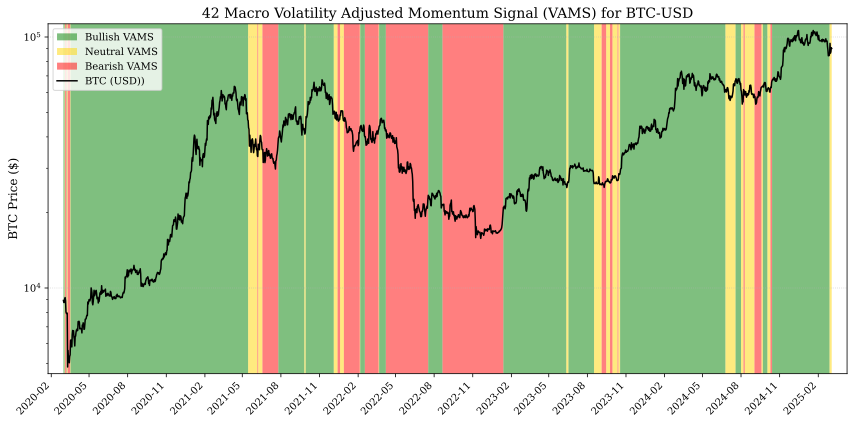

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Create the figure and the primary axes
figga, ax = plt.subplots(figsize=(12, 6))

# --- Add Background Colors ---
signal_colors = {
    'green': to_rgba('green', 0.5),
    'yellow': to_rgba('gold', 0.5),
    'red': to_rgba('red', 0.5),
    'None': to_rgba('white', 1) # Transparent for "None"
}

# Find where the signal changes
signal_changes = vams_data['signal'] != vams_data['signal'].shift(1)
change_indices = vams_data.index[signal_changes].tolist()
# Ensure the first and last dates are included to cover the whole range
if vams_data.index[0] not in change_indices:
    change_indices.insert(0, vams_data.index[0])
if vams_data.index[-1] not in change_indices:
    change_indices.append(vams_data.index[-1])

# Add colored vertical spans (backgrounds)
for i in range(len(change_indices) - 1):
    start_date = change_indices[i]
    end_date = change_indices[i+1]
    # Get the signal value for this period (use the start date's signal)
    signal_value = vams_data.loc[start_date, 'signal']
    # Get the color for this signal
    color = signal_colors.get(signal_value, 'white') # Default to white if signal not found
    
    # Add the vertical span using axvspan
    ax.axvspan(start_date, end_date, facecolor=color, alpha=0.5, zorder=0) 

# Set the label and limits for the left y-axis
ax.set_ylabel('USD', color='black', fontsize=12)
ax.tick_params(axis='y', labelcolor='black')

# Plot the 'BTCUSD' column on the left axis
btc_line = ax.plot(vams_data.index, vams_data['BTCUSD'], color='black', label='BTC (USD))', linewidth=1.5)[0] # Ensure price is above background

# Set the label for the right y-axis and use log scale
ax.set_ylabel('BTC Price ($)', color='black', fontsize=12)
ax.set_yscale('log') # Use logarithmic scale for price
ax.tick_params(axis='y', labelcolor='black')

# --- Formatting ---

# Improve date formatting on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Ticks every 6 months # Auto-rotate date labels

# Add a title
plt.title('42 Macro Volatility Adjusted Momentum Signal (VAMS) for BTC-USD', fontsize=14)

# Create proxy artists for the legend
legend_elements = [
    Patch(facecolor=signal_colors['green'], label='Bullish VAMS'),
    Patch(facecolor=signal_colors['yellow'], label='Neutral VAMS'),
    Patch(facecolor=signal_colors['red'], label='Bearish VAMS'),
    btc_line
]

# Add the legend with the proxy patches
ax.legend(handles=legend_elements, loc='upper left')
# Improve date formatting on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Set the rotation of the labels to 45 degrees
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right') 

# Add grid lines for better readability (optional)
ax.grid(True, axis='y', linestyle='--', alpha=0.6) # Grid for left axis
ax.grid(True, axis='y', linestyle=':', alpha=0.6) # Grid for right axis (price)
ax.margins(0.02, 0.02)
# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [47]:
def plot_signal_colored_timeseries(
    data,
    price_col,
    signal_col,
    signal_colors=None,
    figsize=(12, 6),
    title="Signal Colored Time Series",
    use_log_scale=True,
    date_format='%Y-%m',
    date_interval=3,
    legend_loc='upper left'
):
    """
    Create a time series plot with colored backgrounds based on signal values.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame with DatetimeIndex containing price and signal data
    price_col : str
        Column name for the price data to be plotted
    signal_col : str
        Column name for the signal data that determines background colors
    signal_colors : dict, optional
        Dictionary mapping signal values to colors (RGBA or color names)
        Default: {'green': (0, 0.5, 0, 0.5), 'yellow': (1, 0.84, 0, 0.5), 'red': (1, 0, 0, 0.5)}
    figsize : tuple, optional
        Figure size as (width, height) in inches
    title : str, optional
        Plot title
    use_log_scale : bool, optional
        Whether to use logarithmic scale for price axis
    date_format : str, optional
        Format string for date labels on x-axis
    date_interval : int, optional
        Interval in months between date ticks
    legend_loc : str, optional
        Location of the legend
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.colors import to_rgba
    from matplotlib.patches import Patch
    import pandas as pd
    import numpy as np
    
    # Make a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Fill NaN values with 'None' string
    data_copy[signal_col] = data_copy[signal_col].fillna('None')
    
    # Default signal colors if none provided
    if signal_colors is None:
        signal_colors = {
            'green': to_rgba('green', 0.5),
            'yellow': to_rgba('gold', 0.5),
            'red': to_rgba('red', 0.5),
            'None': to_rgba('white', 1)  # Transparent for "None"
        }
    else:
        # Convert any string colors to rgba
        for key, value in signal_colors.items():
            if isinstance(value, str):
                signal_colors[key] = to_rgba(value, 0.5)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Find where the signal changes
    signal_changes = data_copy[signal_col] != data_copy[signal_col].shift(1)
    change_indices = data_copy.index[signal_changes].tolist()
    
    # Ensure the first and last dates are included
    if data_copy.index[0] not in change_indices:
        change_indices.insert(0, data_copy.index[0])
    if data_copy.index[-1] not in change_indices:
        change_indices.append(data_copy.index[-1])
    
    # Add colored vertical spans (backgrounds)
    used_signals = set()
    
    for i in range(len(change_indices) - 1):
        start_date = change_indices[i]
        end_date = change_indices[i+1]
        
        # Get signal value for this period and convert to string
        signal_value = data_copy.loc[start_date, signal_col]
        signal_key = str(signal_value)
        
        # Get color (default to white if not found)
        color = signal_colors.get(signal_key, to_rgba('white', 0.5))
        
        # Add the vertical span
        ax.axvspan(start_date, end_date, facecolor=color, alpha=0.5, zorder=0)
        
        # Track used signals for legend
        used_signals.add(signal_key)
    
    # Convert the index to datetime64 and the price column to numeric values
    x_values = data_copy.index.to_numpy()
    y_values = pd.to_numeric(data_copy[price_col], errors='coerce').to_numpy()
    
    # Plot the price data directly with numpy arrays to avoid category converter issues
    price_line, = ax.plot(
        x_values,
        y_values,
        color='black',
        label=price_col,
        linewidth=1.5,
        zorder=5  # Ensure line is above background
    )
    
    # Set up logarithmic scale if requested
    if use_log_scale:
        ax.set_yscale('log')
    
    # Format the x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=date_interval))
    
    # Rotate date labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Set labels and title
    ax.set_ylabel(f'{price_col}', color='black', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Create legend elements for used signals
    legend_elements = [Patch(facecolor=signal_colors[s], label=s) for s in used_signals if s in signal_colors]
    legend_elements.append(price_line)
    
    # Add the legend
    ax.legend(handles=legend_elements, loc=legend_loc)
    
    # Add grid lines
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

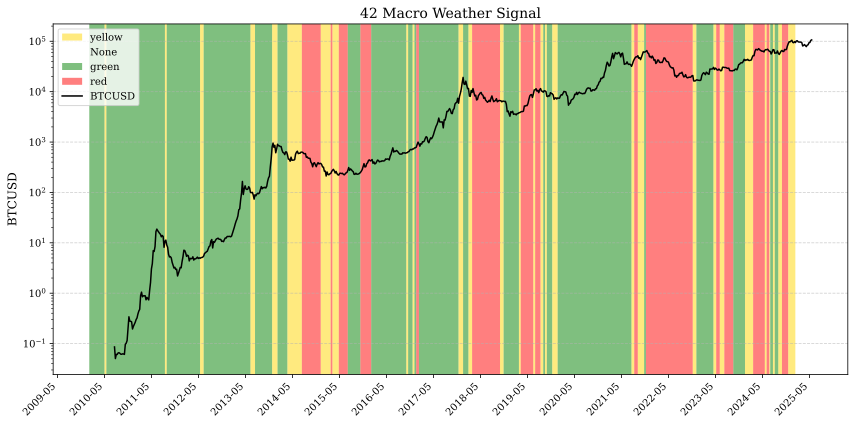

In [48]:
figur,ax = plot_signal_colored_timeseries(
    dataf["2010-01-01":],
    price_col='BTCUSD',
    signal_col='signal',
    signal_colors={
        'green': to_rgba('green', 0.5),
        'yellow': to_rgba('gold', 0.5),
        'red': to_rgba('red', 0.5),
        'None': to_rgba('white', 1)
    },
    title="42 Macro Weather Signal",
    use_log_scale=True,
    date_format='%Y-%m',
    date_interval=12,
    legend_loc='upper left'
)


In [49]:
figur.savefig(vbt_dir+fdel+"MacroWeatherBTC.png", dpi=300, bbox_inches='tight')

In [50]:
mw_recent = dataf["2020-03-01":]
mw_recent

,green,yellow,red,signal,BTCUSD
2020-03-01,1.0,0.0,0.0,green,8563.411686
2020-03-08,1.0,0.0,0.0,green,8110.256078
2020-03-15,1.0,0.0,0.0,green,5391.060249
2020-03-22,1.0,0.0,0.0,green,5833.510610
2020-03-29,1.0,0.0,0.0,green,5929.677884
...,...,...,...,...,...
2025-04-20,NaN,NaN,NaN,NaN,85165.654843
2025-04-27,NaN,NaN,NaN,NaN,93778.871813
2025-05-04,NaN,NaN,NaN,NaN,94478.687833
2025-05-11,NaN,NaN,NaN,NaN,104139.253888


In [51]:
figga.savefig("42macro_vams_signals.png", dpi=300, bbox_inches='tight')

In [52]:
details["taxed"]["stats"]["Total Trades"] = 14; details["taxed"]["stats"]["Total Closed Trades"] = 14
fullstats = pd.concat([bh_pf.stats(), less_ords.stats(), cpf_fo.stats(), details["taxed"]["stats"]], axis=1)
fullstats.columns = ['Buy & Hold (benchmark)',  'Long green, sell yellow/red', "Signal dep. sizing", 'Long green, sell yellow/red (with_tax)']
fullstats

,Buy & Hold (benchmark),"Long green, sell yellow/red",Signal dep. sizing,"Long green, sell yellow/red (with_tax)"
Start,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00
End,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00,2025-03-05 00:00:00
Period,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00,1831 days 00:00:00
Start Value,10000.0,10000.0,10000.0,10000.0
End Value,100538.790869,165512.658278,133564.734484,128609.779231
Total Return [%],905.387909,1555.126583,1235.647345,1186.097792
Benchmark Return [%],908.906766,908.906766,908.906766,1186.097792
Max Gross Exposure [%],100.0,100.0,100.0,100.0
Total Fees Paid,34.877927,7302.532986,5829.146207,0.0
Max Drawdown [%],76.670182,45.062534,50.666528,48.90653
